In [2]:
## Install libraries
%pip install emoji
%pip install eli5
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=144f0549ff43d5e80c1923676e572af552db6b38018645fd41a2efffc116a20a
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 65.0 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=3c9304a3d6353e969eaddffa45654142cbce691c40f38bca9a44e1d9ec0b7e7d
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Ji

In [ ]:
## Imports
import os
import pandas as pd
import numpy as np
#from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import re
import emoji
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import sklearn
import eli5
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from collections import Counter
from sklearn.neural_network import MLPClassifier

In [ ]:
## Pandas Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [1]:
## Connection to Google Drive
#drive.mount('/content/gdrive')

#path = '/content/gdrive/MyDrive/colab_notebooks/ML4NLP/Ex1'
#os.chdir(path)

In [ ]:
## Helper Functions
def load_dataset(filename):
    df = pd.read_csv(filename, sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [ ]:
## Load Data Sets
df_train_dev = load_dataset('https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv')
df_test = load_dataset('https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv')

training size:  (52675, 2)
test size:  (13279, 2)


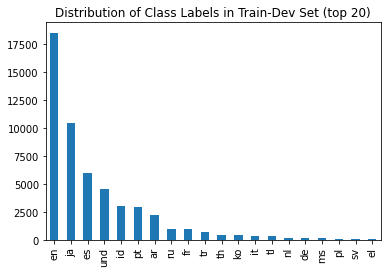

In [ ]:
## Inspect the Data
print('training size: ', df_train_dev.shape)
print('test size: ', df_test.shape)

df_train_dev.label.value_counts()[0:20].plot(kind='bar', title='Distribution of Class Labels in Train-Dev Set (top 20)')

In [ ]:
## Split the data into tweets and labels
X_train_dev = df_train_dev.tweet
y_train_dev = df_train_dev.label
X_test = df_test.tweet
y_test = df_test.label

In [ ]:
## Split the train data into train and dev set according to 90/10 split
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.1, random_state=1)

In [ ]:
## Define functions for preprocessing
def remove_url(text):
  re_url = re.compile('https?://\S+|www\.\S+')
  return re_url.sub('', text)

def remove_twitterUsername(text):
  re_user = re.compile(r'@([A-Za-z0-9_]+)')
  return re_user.sub('', text)

def convert_emojis(text):
  return emoji.demojize(text)

def pipelinize(function, active=True):
  def list_comprehend_a_function(list_or_series, active=True):
      if active:
          return [function(i) for i in list_or_series]
      else:
          return list_or_series
  return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})


def get_avg_word_length(text):
  if not text.split():
    return 0
  else:
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / len(words)
    return avg_word_length

def get_tweet_length(text):
  return len(text)

def reshape_a_feature_column(series):
  return np.reshape(np.asarray(series), (len(series), 1))

def pipelinize_feature(function, active=True):
  def list_comprehend_a_function(list_or_series, active=True):
        if active:
            processed = [function(i) for i in list_or_series]
            processed = reshape_a_feature_column(processed)
            return processed
        else:
            return reshape_a_feature_column(np.zeros(len(list_or_series)))
  return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [ ]:
## Create pipeline

# Define two extra linguistic features
linguistic_feature_1 = 'avg_word_length'
linguistic_feature_2 = 'tweet_length'

# Generate pipeline with LogisticRegression as classifier
pipeline = Pipeline([
    ('clean_URLs', pipelinize(remove_url)),
    ('clean_usernames', pipelinize(remove_twitterUsername)),
    ('clean_emojis', pipelinize(convert_emojis)),
    ('features', FeatureUnion([
        ('tf_idf_vectorizer', TfidfVectorizer()),
        (linguistic_feature_1 + '_scaled', Pipeline([
            (linguistic_feature_1, pipelinize_feature(get_avg_word_length, active=True)),
            ('scaler', StandardScaler())
            ])
        ),
        (linguistic_feature_2 + '_scaled', Pipeline([
            (linguistic_feature_2, pipelinize_feature(get_tweet_length, active=True)),
            ('scaler', StandardScaler())
            ])
        )
    ])),
    ('classifier', MLPClassifier())
  ])

In [ ]:
## Define PredefinedSplit in order to use the 90/10 train and development (validation) split
## (k-fold CV does not work since this does not follow the 90/10 split as outlined in exercise statement)

train_size = len(y_train)
dev_size = len(y_dev)

X_train_dev = pd.concat([X_train, X_dev], ignore_index=True)
y_train_dev = pd.concat([y_train, y_dev], ignore_index=True)

# Set indices to be used for training (=first m elements of stacked train_dev array with m=len(y_train))
train_indices = np.full((train_size, ), -1, dtype=int)

# The indices which have zero or positive values, will be kept in dev
dev_indices = np.full((dev_size, ), 0, dtype=int)
fold = np.append(train_indices, dev_indices)

custom_split = PredefinedSplit(fold)

In [ ]:
## GridSearch for optimal hyperparameter

# Define search space / hyperparameter grid
param_grid = {'classifier__hidden_layer_sizes': [(100, ), (10, 10, 10)],
              'classifier__activation': ['tanh', 'relu'],
              'classifier__solver': ['adam', 'lbfgs'],
              'classifier__early_stopping': [True, False],
              'classifier__max_iter': [20],
              'features__tf_idf_vectorizer__ngram_range': [(1, 1), (1, 2)],
              'features__tf_idf_vectorizer__max_features': [500, 1000]
              }

# Perform the GridSearch using the previously defined 90/10 train/development(validation) splits in the cross validation
grid_search = GridSearchCV(pipeline, param_grid, cv=custom_split, n_jobs=4, verbose=1, refit=True)

In [ ]:
## Fitting (X_train_dev, y_train_dev will be split into train and dev(validation) set using the split defined above)
grid_search.fit(X_train_dev, y_train_dev)

Fitting 1 folds for each of 64 candidates, totalling 64 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('clean_URLs',
                                        FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7f7bf0f55290>,
                                                            kw_args={'active': True})),
                                       ('clean_usernames',
                                        FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7f7bef20e950>,
                                                            kw_...
                                       ('classifier', MLPClassifier())]),
             n_jobs=4,
             param_grid={'classifier__activation': ['tanh', 'relu'],
                         'classifier__early_stopping': [True, False],
                         'classifier__hidden_layer_sizes': [(100,),
                                                            (10, 10, 10

In [ ]:
print("Mean score (accuracy) on validation set: %0.3f" % grid_search.best_score_)
print("Best parameters set (measured by achieved score on development(validation) set):")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Mean score (accuracy) on validation set: 0.804
Best parameters set (measured by achieved score on development(validation) set):
	classifier__activation: 'relu'
	classifier__early_stopping: False
	classifier__hidden_layer_sizes: (100,)
	classifier__max_iter: 20
	classifier__solver: 'adam'
	features__tf_idf_vectorizer__max_features: 1000
	features__tf_idf_vectorizer__ngram_range: (1, 1)


In [ ]:
## Make predictions on unseen test set
y_pred = grid_search.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print("Mean score (accuracy) on unseen test set: %0.3f" % acc_test)

Mean score (accuracy) on unseen test set: 0.807


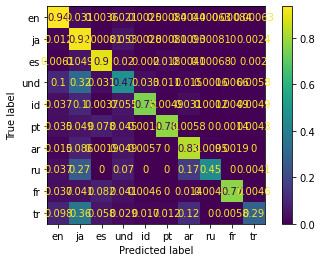

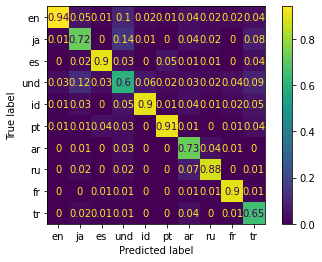

In [ ]:
## Create confusion matrix

# Get 10 most common labels in test set for clearer visualizations of confusion matrix
c = Counter(y_test)
c_top10 = c.most_common(10)

labels_top10 = [i[0] for i in c_top10]

# Generate confusion matrix
conf_mx = confusion_matrix(y_test, y_pred, normalize='true', labels=labels_top10)

disp = ConfusionMatrixDisplay(conf_mx, display_labels=labels_top10)
disp.plot()
plt.savefig('cm_mlp_true.png')
plt.show()

# Generate confusion matrix (normalized to predictions)
conf_mx = confusion_matrix(y_test, y_pred, normalize='pred', labels=labels_top10).round(2)

disp = ConfusionMatrixDisplay(conf_mx, display_labels=labels_top10)
disp.plot()
plt.savefig('cm_mlp_pred.png')
plt.show()

In [ ]:
## Print the number of predictions for top 10 predicted classes
c = Counter(y_pred)
c_top10 = c.most_common(10)

print("Top 10 predicted classes: ")
print(c_top10)

Top 10 predicted classes: 
[('en', 4813), ('ja', 3384), ('es', 1532), ('und', 1054), ('id', 689), ('ar', 613), ('pt', 602), ('fr', 190), ('ru', 131), ('tr', 68)]


In [ ]:
## Create feature importance table

# Extract feature importance (=weights) from best classifier (i.e., best-performing according to Gridsearch)
#best_estimator = grid_search.best_estimator_
#classifier = best_estimator.named_steps['classifier']

# Extract feature names from the pipeline
#feature_names_vectorizer = dict(best_estimator.named_steps['features'].transformer_list).get('tf_idf_vectorizer').get_feature_names_out()

# Account for extra linguistic features
#feature_names_all = np.append(feature_names_vectorizer, [linguistic_feature_1, linguistic_feature_2])

# Display feature importance table
#eli5.show_weights(classifier, feature_names=feature_names_all, top=10, targets=['en', 'es', 'ja'])